In [1]:
import ogr
import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
daShapefile = "SDM324649_full/ll_gda94/sde_shape/whole/VIC/CATCHMENTS/layer/landuse_2014.shp"

driver = ogr.GetDriverByName('ESRI Shapefile')

dataSource = driver.Open(daShapefile, 0) # 0 means read-only. 1 means writeable.

# Check to see if shapefile is found.
if dataSource is None:
    print('Could not open %s' % (daShapefile))
else:
    print('Opened %s' % (daShapefile))
    layer = dataSource.GetLayer()
    featureCount = layer.GetFeatureCount()
    print("Number of features: %d" % (featureCount))

Opened SDM324649_full/ll_gda94/sde_shape/whole/VIC/CATCHMENTS/layer/landuse_2014.shp
Number of features: 3522855


In [3]:
# select shapes in the area of interest
# area_filter = "POLYGON ((143.32317350376297 -37.496296386368165, 143.32180000642074 -37.70330610816869,\
#                         143.59543478539388 -37.70317028876007, 143.5968081449812 -37.49575155973978,\
#                         143.32317350376297 -37.496296386368165))"
area_filter = "POLYGON ((142.79501249253747 -37.62573016158374, 142.79363481285884 -37.832739875957245,\
                        143.06774894788782 -37.83260406398416, 143.0691229156846 -37.62518532754736,\
                        142.79501249253747 -37.62573016158374))"
filter_poly = ogr.CreateGeometryFromWkt(area_filter)

layer.SetSpatialFilter(filter_poly)
layer.GetFeatureCount()

1742

In [4]:
layerDefinition = layer.GetLayerDefn()
[layerDefinition.GetFieldDefn(i).GetName() for i in range(layerDefinition.GetFieldCount())]

['PARCEL_PFI',
 'PARCEL_SPI',
 'PC_LGAC',
 'LGA',
 'CMA',
 'PR_PROPNUM',
 'PROP_PFI',
 'LU_CODE',
 'LU_DESC',
 'LU_1',
 'LU_2',
 'LU_3',
 'LC_CODE_14',
 'LC_CODE_15',
 'LC_DESC_14',
 'LC_DESC_15',
 'HECTARES',
 'TENURE',
 'IRR_STATUS']

In [5]:
unique_classes = np.unique([feature.items()['LC_DESC_14'] for feature in layer])

In [6]:
print(unique_classes)

['Brassicas' 'Cereals' 'Legumes' 'Pasture and grassland' 'Unknown' 'Water']


In [12]:
unique_classes_dict = {i + 1: unique_classes[i] for i in range(len(unique_classes))}
unique_classes_dict[0] = 'No data'
temp = unique_classes_dict[6]
unique_classes_dict[6] = unique_classes_dict[5]
unique_classes_dict[5] = temp
unique_classes_dict

{0: 'No data',
 1: 'Brassicas',
 2: 'Cereals',
 3: 'Legumes',
 4: 'Pasture and grassland',
 5: 'Water',
 6: 'Unknown'}

In [13]:
for i, cls in unique_classes_dict.items():
    layer.SetAttributeFilter("LC_DESC_14 = '%s'" % cls)
    print("%s: %d" % (cls, layer.GetFeatureCount()))
layer.SetAttributeFilter(None)

No data: 0
Brassicas: 189
Cereals: 419
Legumes: 3
Pasture and grassland: 298
Water: 1
Unknown: 839


0

In [16]:
# draw regions class by class
NoData_value = 0
layer.SetAttributeFilter(None)
x_min, x_max, y_min, y_max = filter_poly.GetEnvelope()
x_res = 1022
y_res = 973
pixel_size = (x_max - x_min) / x_res

target_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, gdal.GDT_Byte)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
# target_ds.SetGeoTransform((x_max, pixel_size, 0, y_min, 0, -pixel_size))
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(NoData_value)
empty_array = np.ones((y_res, x_res)) * NoData_value
band.WriteArray(empty_array)

# Rasterize

# layer.SetAttributeFilter("LC_DESC_14 = '%s'" % unique_classes_dict[6])
# gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[1])

for i, cls in unique_classes_dict.items():
    if i != 0:
        layer.SetAttributeFilter("LC_DESC_14 = '%s'" % cls)
        gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[i])

layer.SetAttributeFilter(None)

0

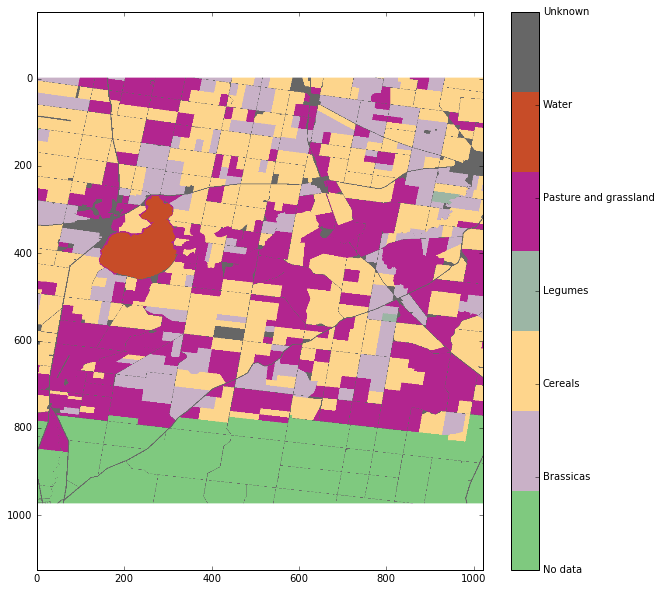

In [17]:
array = band.ReadAsArray()
plt.figure(figsize=(10, 10))
plt.axis('equal')
im = plt.imshow(array, cmap=plt.cm.get_cmap('Accent', len(unique_classes_dict)))
plt.colorbar(ticks=[0,1,2,3,4,5,6], format=plt.FuncFormatter(lambda val, loc: unique_classes_dict[val]))
plt.show()